In [10]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
from astropy.cosmology import Planck18, z_at_value
from astropy.constants import c
from scipy.ndimage.filters import gaussian_filter
import astropy.units as u
import hankl
from scipy import interpolate
from scipy.integrate import quadrature
from scipy.special import jv
from scipy.interpolate import interp1d
from scipy.interpolate import UnivariateSpline
from sympy.physics.wigner import wigner_3j
from scipy.integrate import quadrature

%matplotlib inline

/var/folders/l0/bsqsn6_s01b0hvjnf7bv_wdw0000gn/T/ipykernel_72943/3140175382.py:6: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter


# Calculate $C_l^{\Delta \phi \Delta \phi}(k_1,k_2)$ (for insight)

TODO: Check this part for missing factors of 2

Note that we don't actually need this quantity to evaluate the biases, we just do it for insight

Let us rerun everything using a different sampling in r so that FFTLog converges

/Users/antonbaleatolizancos/opt/anaconda3/envs/varying_dndz/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (500) exceeded. Latest difference = 3.378991e-09
  warnings.warn(


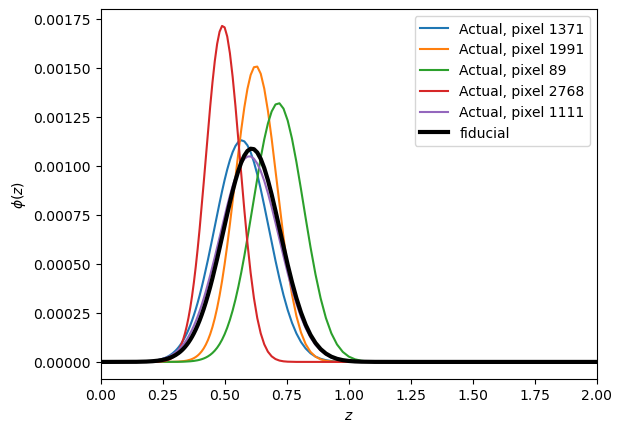

In [20]:
# Suppose the dndz changes across different healpixels
nside = 16 # Nside that sets the size of pixels over which dn/dz is constant
npix = hp.nside2npix(nside)

# Initialize samples in r (r is comoviing distance throughout)
n_samples_of_chi = 2**10 # Choose a power of 2

log_rmin = -4 # Choose integers here
log_rmax = 4 # Choose integers here
r_array = np.logspace(log_rmin,log_rmax,n_samples_of_chi) 
'''
lin_rmin = Planck18.comoving_distance(z_min_int).value
lin_rmax = Planck18.comoving_distance(z_max_int).value
r_array = np.linspace(lin_rmin,lin_rmax,n_samples_of_r) 
'''

# Get the redshift corresponding to these values of r in the Planck18 cosmology
z_array = np.zeros((npix, n_samples_of_chi))
for i, chi in enumerate(chi_array):
    z_array[:, i] = z_at_value(Planck18.comoving_distance, chi* u.Mpc) 
    
sigma_zshift = z_mean/10. # Standard deviation of the shifts in the central redshift of the distribution
sigma_zwidth = sigma/10. # Standard deviation of the variations in the width of the distribution

modulation_of_mean_of_draws = 0 #modulating_map # Consider also modulating the mean of these shifts across the sky

# Draw random values in each pixel for the shift of the central redshift of the dndz
zmean_shifts_array = np.random.normal(loc=modulation_of_mean_of_draws, scale=sigma_zshift, size=npix)
width_shifts_array = np.random.normal(loc=modulation_of_mean_of_draws, scale=sigma_zwidth, size=npix)

# In each pixel, calculate the perturbed dndz as a Gaussian in redshift
dndz_perturbed = (1/((sigma+width_shifts_array[..., np.newaxis])*np.sqrt(2*np.pi))) * np.exp(-(z_array - z_mean - zmean_shifts_array[..., np.newaxis])**2 /(2*(sigma+width_shifts_array[..., np.newaxis])**2))
# Take the fiducial dndz to be the monopole of the perturbed dndz
dndz_fid = np.mean(dndz_perturbed, axis=0)

# Convert dndz to selection function
phi_perturbed_array = (Planck18.H(z_array[0,:]) / c).value * dndz_perturbed
phi_fid_array = (Planck18.H(z_array[0,:]) / c).value * dndz_fid

# Normalize the selection function so that \int_{0}^{inf} dr phi(r) = 1
phi_norm, error = quadrature(interp1d(r_array, phi_fid_array), Planck18.comoving_distance(z_min_int).value, 
                                       Planck18.comoving_distance(z_max_int).value,
                                             tol=1e-20, maxiter=500)
phi_perturbed_array *= phi_norm**(-1)
phi_fid_array *= phi_norm**(-1)
phi_fid = interp1d(r_array, phi_fid_array)

# Extract the perturbation
delta_p_maps = phi_perturbed_array - phi_fid_array

# Plot some typical realizations
for pixel_id in np.random.randint(0,npix,5):
    plt.plot(z_array[0,:], phi_perturbed_array[pixel_id,:], label='Actual, pixel {}'.format(pixel_id))

# Plot the fiducial dndz
plt.plot(z_array[0,:], phi_fid_array, color='k', lw=3, label='fiducial')

plt.ylabel(r'$\phi(z)$')
plt.xlabel(r'$z$')
plt.xlim([0,2])
plt.legend()

# Let us up-sample the maps
nside_out = 64 # If running on a laptop, don't go above nside_out=128 (nside_out = 256 already requires 20Gb of memory)

delta_p_maps_upsampled = np.zeros((hp.nside2npix(nside_out), n_samples_of_r))
for i in range(len(r_array)):
    delta_p_maps_upsampled[:,i] = hp.ud_grade(delta_p_maps[:,i], nside_out)
    
delta_p_maps = delta_p_maps_upsampled

# To avoid ringing due to the hard edges on which we seed the anisotropy, we smooth the maps with a Gaussian 
# with sigma equal to 1/2 of the typical width one of the big pixels (characterized by nside, not nside_out)
sigma_gaussian_smoothing = np.sqrt(4*np.pi/npix)/2. * (360*60/(2*np.pi)) # in arcmin

def bl(fwhm_arcmin, lmax):
    """ returns the map-level transfer function for a symmetric Gaussian beam.
         * fwhm_arcmin      = beam full-width-at-half-maximum (fwhm) in arcmin.
         * lmax             = maximum multipole.
    """
    ls = np.arange(0, lmax+1)
    return np.exp( -(fwhm_arcmin * np.pi/180./60.)**2 / (16.*np.log(2.)) * ls*(ls+1.) )

beam = bl(sigma_gaussian_smoothing, 3*nside_out-1)

# Take the spherical harmonic transform of each r slice. Conveniently, we can take complex SHT so array sizes reduce by x2
delta_p_lm_of_r = np.zeros((hp.Alm.getsize(3*nside_out-1), n_samples_of_r), dtype=complex)
for i in range(n_samples_of_r):
    delta_p_lm_of_r[:,i] = hp.map2alm(delta_p_maps[:,i])
    # Smooth the map to reduce ringing due to the hard edges of the big pixels
    delta_p_lm_of_r[:,i] = hp.almxfl(delta_p_lm_of_r[:,i], beam) 

In [21]:
# Next, we will want to take the (l+1/2)th order Hankel transform of each theta_alm
delta_p_lm_of_k = np.zeros_like(delta_p_lm_of_r) 
Cl_deltap_of_k1_k2 = np.zeros((lmax+1, n_samples_of_r, n_samples_of_r))

for i in range(delta_p_lm_of_r.shape[0]):
    if i % 1000 == 0:
        # Print progress
        print('Completed {}%'.format(round(100*i/delta_p_lm_of_r.shape[0]), 3))
    l, m = hp.Alm.getlm(lmax, i) # Get the l corresponding to each value of m
    # Now get the Hankel transforms.
    # Importantly, after discussing with Minas, we use the Stirling approximation to the gamma functions in Eqn 16 
    # of https://jila.colorado.edu/~ajsh/FFTLog/fftlog.pdf, which diverges for mu>342
    k_array, delta_p_lm_of_k[i,:] = hankl.FFTLog(r_array, r_array*delta_p_lm_of_r[i,:], q=0, mu=l+0.5, ext=1, lowring=True, stirling_cutoff=-1)
    delta_p_lm_of_k[i,:] *= 1./k_array # Adapt to the convention in the Hankl code
    # Get angular PS and deconvolve pixel window function for all possible combinations of k1 and k2 
    Cl_deltap_of_k1_k2[l,:,:] += np.outer(delta_p_lm_of_k[i,:], np.conj(delta_p_lm_of_k[i,:])).real/ (2*l+1) / pixwinf[l]**2

Completed 0%


/Users/antonbaleatolizancos/opt/anaconda3/envs/varying_dndz/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)


Completed 5%
Completed 11%
Completed 16%
Completed 22%
Completed 27%
Completed 32%
Completed 38%
Completed 43%
Completed 49%
Completed 54%
Completed 59%
Completed 65%
Completed 70%
Completed 76%
Completed 81%
Completed 86%
Completed 92%
Completed 97%


### Visualizing $C_l^{\Delta \phi \Delta \phi}(k)$

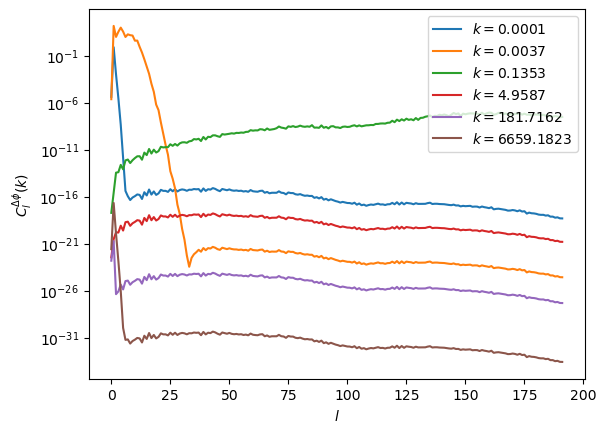

In [22]:
for k_idx, k in zip(np.arange(len(k_array))[::200], k_array[::200]):
    plt.semilogy(Cl_deltap_of_k1_k2[:,k_idx, k_idx], label=r'$k={}$'.format(round(k, 4)))
plt.xlabel(r'$l$')
plt.ylabel(r'$C_l^{\Delta \phi}(k)$')
plt.legend()

There are large oscillations above l>350, probably due to the fact that we've had to use Stirling's approximation in FFTLog, but they happen many orders of magnitude below the dominant signal and can probably be ignored. Also, are the bumps at low $l$ physical, or are they numerical artifacts?

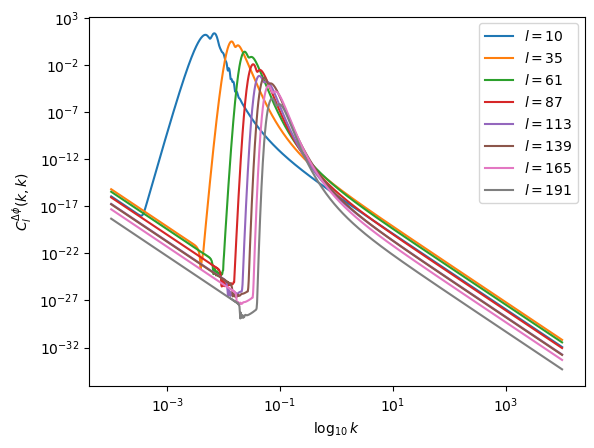

In [23]:
for l_to_plot in np.linspace(10,lmax,8, dtype=int):
    plt.loglog(k_array, np.diagonal(Cl_deltap_of_k1_k2, axis1=1, axis2=2)[l_to_plot,:], label=r'$l={}$'.format(l_to_plot))
plt.xlabel(r'$\mathrm{log}_{10}\,k$')
plt.ylabel(r'$C_l^{\Delta \phi}(k, k)$')
plt.legend()


In [24]:
X, Y = np.meshgrid(np.arange(len(k_array)), np.arange(lmax+1))
Z = np.log10(np.diagonal(Cl_deltap_of_k1_k2, axis1=1, axis2=2))

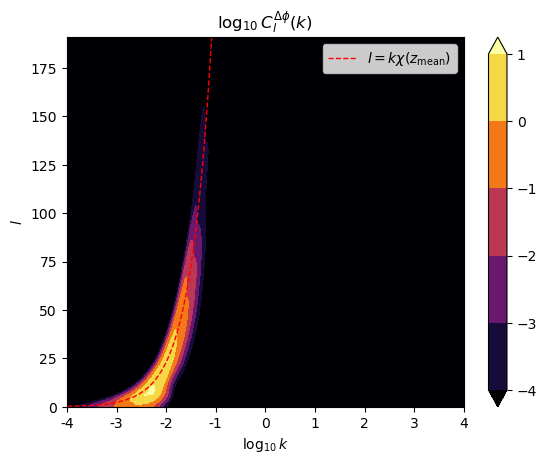

In [25]:
contours = np.arange(-4,2,1)

# Smooth array with a Gaussian filter for plotting purposes
Z_smoothed = gaussian_filter(Z, sigma=3)
plt.contourf(X, Y, Z_smoothed, levels=contours, cmap='inferno', extend='both')

plt.xlabel(r'$\mathrm{log}_{10}\,k$')
plt.ylabel(r'$l$')

ax = plt.gca()
ax.plot(k_array*Planck18.comoving_distance(z_mean).value, color='r', ls='--', lw=1, label=r'$l=k \chi(z_{\mathrm{mean}})$')
ax.set_ylim([0,lmax])

label_locs = np.arange(int(round(np.log10(np.min(k_array)),0)), int(round(np.log10(np.max(k_array)),0))+1, 1)
ax.set_xticks(np.linspace(0, len(k_array), len(label_locs)))
ax.set_xticklabels(label_locs.astype('str'))
plt.legend()

plt.title(r'$\mathrm{log}_{10} \, C_l^{\Delta \phi}(k)$')
plt.colorbar(location='right')

#ax.set_xlim([0,530])

- It's worth investigating the behaviour at low k
- How can there be any angular anisotropy at such high (even if suppressed many orders of magnitude relative to the peak signal) if we seeded the perturbations radially on a healpix pixelization characterized by very low nside?

### Visualizing $C_l^{\Delta \phi \Delta \phi}(k_1,k_2)$

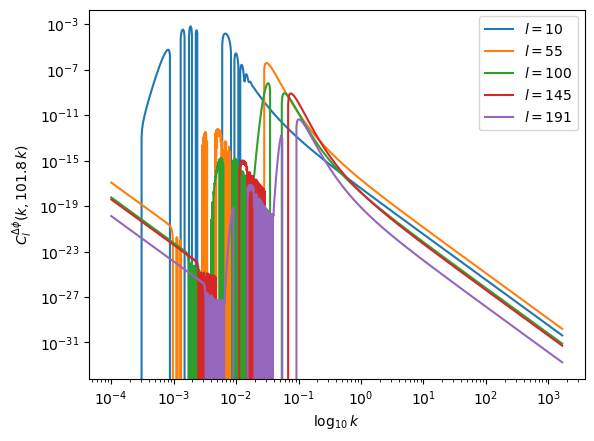

In [26]:
# Let us look into an offset diagonal
offset_idx = 100
offset_k = round((k_array[1]/k_array[0])*offset_idx,1)

for l_to_plot in np.linspace(10,lmax,5, dtype=int):
    plt.loglog(k_array[:-offset_idx], np.diagonal(Cl_deltap_of_k1_k2, axis1=1, axis2=2, offset=offset_idx)[l_to_plot,:], label=r'$l={}$'.format(l_to_plot))
plt.xlabel(r'$\mathrm{log}_{10}\,k$')
plt.ylabel(r'$C_l^{\Delta \phi}(k, $'+str(offset_k)+'$\,k)$')

plt.legend()

Wild oscillations ensue once the shift becomes larger than a few tens, so I don't expect any signal to come from regimes with a larger shift

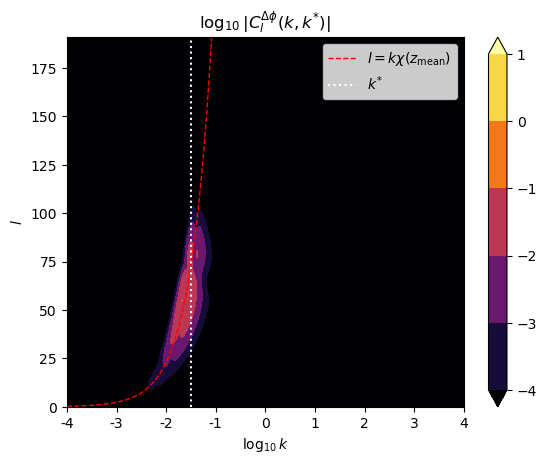

In [27]:
k_idx = np.where(np.log10(k_array)>-1.5)[0][0]

Z_fixed_k = np.log10(np.abs(Cl_deltap_of_k1_k2[:,:,k_idx]))
# Smooth array with a Gaussian filter for plotting purposes
Z_fixed_k_smoothed = gaussian_filter(Z_fixed_k, sigma=3)

plt.contourf(X, Y, Z_fixed_k_smoothed, levels=contours, cmap='inferno', extend='both')

plt.xlabel(r'$\mathrm{log}_{10}\,k$')
plt.ylabel(r'$l$')

ax = plt.gca()
ax.plot(k_array*Planck18.comoving_distance(z_mean).value, color='r', ls='--', lw=1, label=r'$l=k \chi(z_{\mathrm{mean}})$')
ax.set_ylim([0,lmax])

label_locs = np.arange(int(round(np.log10(np.min(k_array)),0)), int(round(np.log10(np.max(k_array)),0))+1, 1)
ax.set_xticks(np.linspace(0, len(k_array), len(label_locs)))
ax.set_xticklabels(label_locs.astype('str'))

plt.title(r'$\mathrm{log}_{10} \, |C_l^{\Delta \phi}(k,k^{*})|$')
plt.colorbar(location='right')

ax.axvline(k_idx, label=r'$k^{*}$', ls=':', color='w')
plt.legend()
#ax.set_xlim([0,530])


This suggests that, at a fixed $l$, it might be ok to assume  $C^{\Delta \phi \Delta \phi}_l(k_1,k_2) \approx \delta_{\mathrm{D}}(k_1-k_2)C^{\Delta \phi \Delta \phi}_l(k_1,k_1)$, especially when $l\gtrapprox 50$. Note, however, that this might no longer hold if in reality there is some anisotropy to the template, and in fact we don't draw from exactly the same distribution in every pixel. Actually, see latest discussion in paper.

# Testing FFTLog

/Users/antonbaleatolizancos/opt/anaconda3/envs/varying_dndz/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


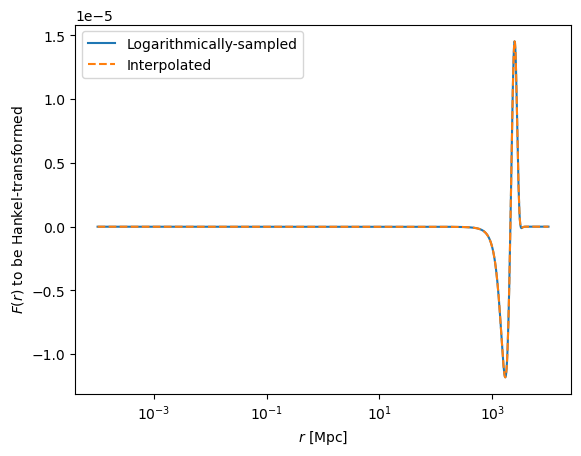

/var/folders/l0/bsqsn6_s01b0hvjnf7bv_wdw0000gn/T/ipykernel_20405/1740207689.py:34: ComplexWarning: Casting complex values to real discards the imaginary part
  p_lm_singlek[i], err[i] = quadrature(integrand, Planck18.comoving_distance(0.01).value,


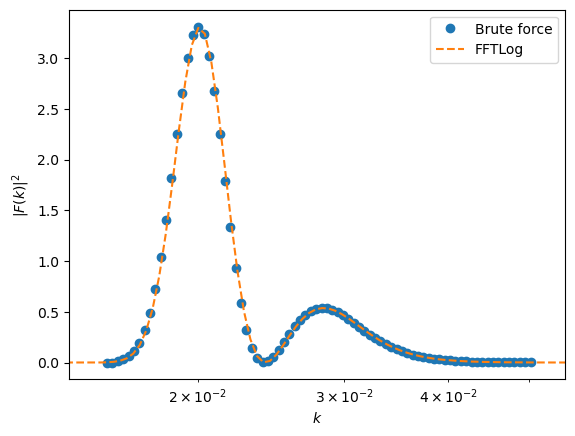

In [28]:
# Choose just one of the m's that we want to Hankel-transform. We will run our test on this one alone
test_idx = 50
# We will need the l corresponding to this m to compute the (l+0.5)th order Hankel transform
test_l, test_m = hp.Alm.getlm(lmax, test_idx) 

# Interpolate the function to be Hankel transformed so we can do it by brute-force
inter_func = interpolate.interp1d(r_array, delta_p_lm_of_r[test_idx,:], bounds_error=True)
plt.semilogx(r_array, delta_p_lm_of_r[test_idx,:], label='Logarithmically-sampled')
plt.semilogx(r_array, inter_func(r_array), ls='--', label='Interpolated')
plt.xlabel(r'$r$ [Mpc]')
plt.ylabel(r'$F(r)$ to be Hankel-transformed')
plt.legend()
plt.show()

# First, integrate using FFTLog
test_k_array, test_delta_p_lm_of_k = hankl.FFTLog(r_array, r_array*delta_p_lm_of_r[test_idx,:], q=0, 
                                                  mu=test_l+0.5, ext=2, lowring=True)
result_fftlog = test_delta_p_lm_of_k*np.conj(test_delta_p_lm_of_k)/test_k_array**2

# Compare to a brute-force numerical integration
def integrand(r, k, test_l):
    # The integrand of the Hankel transform we want
    return inter_func(r) * r * jv(test_l + 0.5, k*r)

# Use the FFTlog calculation to refine the domain overwhich we do brute force
log_kmin_bruteforce = np.log10(test_k_array[np.where(result_fftlog>0.001)[0][0]])
log_kmax_bruteforce = np.log10(test_k_array[np.where(result_fftlog>0.001)[0][-1]])

shortened_test_k_array = np.logspace(log_kmin_bruteforce, log_kmax_bruteforce, 80)
p_lm_singlek = np.zeros_like(shortened_test_k_array)
err = np.zeros_like(shortened_test_k_array)
for i, test_k in enumerate(shortened_test_k_array):
    # At a few values of k, get the Hankel transform by brute force
    p_lm_singlek[i], err[i] = quadrature(integrand, Planck18.comoving_distance(0.01).value, 
                                   Planck18.comoving_distance(10).value, args=(test_k, test_l),
                                         tol=1e-5,  maxiter=1000)

plt.semilogx(shortened_test_k_array, p_lm_singlek*np.conj(p_lm_singlek), ls='none', marker='o', label='Brute force')
plt.semilogx(test_k_array, result_fftlog, ls='--', label='FFTLog')
plt.xlabel(r'$k$')
plt.ylabel(r'$|F(k)|^2$')
plt.xlim([10**log_kmin_bruteforce*0.9, 10**log_kmax_bruteforce*1.1])
plt.legend()